<a href="https://colab.research.google.com/github/smartinot/DL_assignment/blob/master/mn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf 
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MSE, categorical_crossentropy
from tensorflow.keras.regularizers import l2
import sys

Using TensorFlow backend.


In [0]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

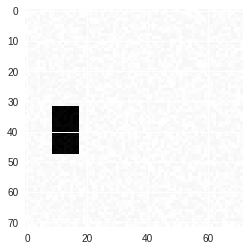

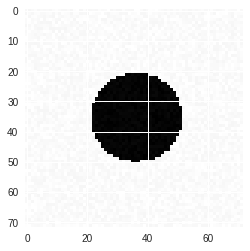

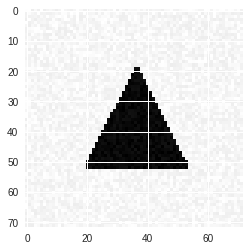

In [3]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray'); plt.show()

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray'); plt.show()

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray'); plt.show()

# 1. Simple classification problem

Here we compare SGD and Adam optimizers : we observe that the SGD optimizer gives noisier loss curves than Adam : the momentum in Adam does help pinpoint the actual minimum with more precision and is faster to converge.

In [0]:
## Classification
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    sys.stdout.write('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            sys.stdout.write('.')
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    sys.stdout.write('Finished')
    return [X, Y]

def generate_test_set_classification(n_samples, noise, free_location=False):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(n_samples, noise, free_location)
    return [X_test, Y_test]

### a. Loading training, validation and test sets for classification and conversion to one-hot labels

In [5]:
n_train = 300
n_val = 50
n_test = 50
noise = 20

# Generate training, validation and testing sets
[X_train, Y_train] = generate_dataset_classification(n_train, noise)
[X_val, Y_val] = generate_test_set_classification(n_val, noise)
[X_test, Y_test] = generate_test_set_classification(n_test, noise)

print('Converting labels to one-hot labels')
Y_train = keras.utils.to_categorical(Y_train)
Y_val = keras.utils.to_categorical(Y_val)
Y_test = keras.utils.to_categorical(Y_test)

Creating data:...FinishedCreating data:.FinishedCreating data:.FinishedConverting labels to one-hot labels


### b. Creating the model : a linear classifier is composed of a single dense layer with n_classes neurons.

In [0]:
def my_linear_classifier(X_train, lr=0.01, n_classes=3, loss='categorical_crossentropy', metric='accuracy', optimizer='SGD'):
    _, input_size = X_train.shape
    
    model = Sequential()
    model.add(Dense(n_classes, input_shape=(input_size,), use_bias=True))
    model.add(Activation(activation='softmax'))

    if optimizer=='SGD':
        model.compile(optimizer=SGD(lr=lr), loss=loss, metrics=[metric])
    if optimizer=='Adam':
        model.compile(optimizer=Adam(lr=lr), loss=loss, metrics=[metric])
    return model

### c. Training the model (SGD then Adam) - Learning Curves - Model Evaluation

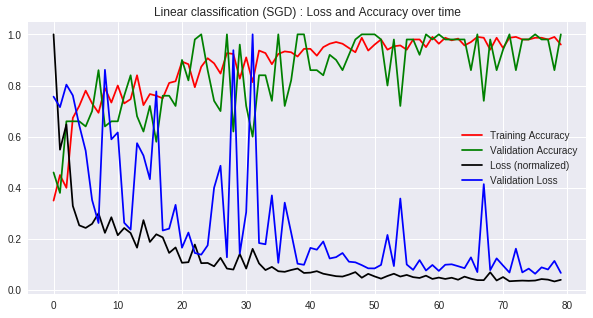

Accuracy over test set  1.0


In [7]:
# Linear Classifier with SGD Optimizer

linear_classifier = my_linear_classifier(X_train, lr=0.003)

n_epochs = 80
linear_history = linear_classifier.fit(X_train, Y_train, batch_size=32, 
                                       epochs=n_epochs, 
                                       validation_data=[X_val, Y_val], 
                                       verbose=0)

# Learning curves
plt.figure(figsize=(10,5))
plt.plot(linear_history.history['acc'], 'r', label='Training Accuracy')
plt.plot(linear_history.history['val_acc'], 'g', label='Validation Accuracy')
plt.plot(linear_history.history['loss']/np.max(linear_history.history['loss']), 'k', label='Loss (normalized)')
plt.plot(linear_history.history['val_loss']/np.max(linear_history.history['val_loss']), 'b', label='Validation Loss')
plt.legend()
plt.title('Linear classification (SGD) : Loss and Accuracy over time')
plt.show()

# Model evaluation
print('Accuracy over test set ', linear_classifier.evaluate(X_test, Y_test, verbose=0)[1])

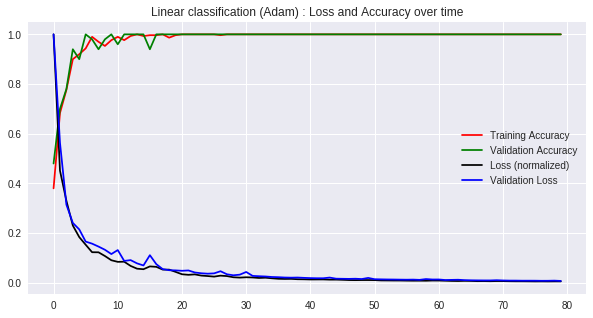

Accuracy on test set :  1.0


In [8]:
# Linear Classifier with Adam Optimizer
linear_adam = my_linear_classifier(X_train, lr=0.001, optimizer='Adam')

n_epochs = 80
history_adam = linear_adam.fit(X_train, Y_train, batch_size=32, 
                               epochs=n_epochs, 
                               validation_data=[X_val, Y_val], 
                               verbose=0)

# Learning curves
plt.figure(figsize=(10,5))
plt.plot(history_adam.history['acc'], 'r', label='Training Accuracy')
plt.plot(history_adam.history['val_acc'], 'g', label='Validation Accuracy')
plt.plot(history_adam.history['loss']/np.max(history_adam.history['loss']), 'k', label='Loss (normalized)')
plt.plot(history_adam.history['val_loss']/np.max(history_adam.history['val_loss']), 'b', label='Validation Loss')
plt.legend()
plt.title('Linear classification (Adam) : Loss and Accuracy over time')
plt.show()

# Model evaluation
print('Accuracy on test set : ', linear_adam.evaluate(X_test, Y_test, verbose=0)[1])

# 2. Visualizing the solution : Looking at the model's learned weigths


The weights trained with Adam optimizer give cleaner filters 

### a. Weigths of the classifier trained with SGD

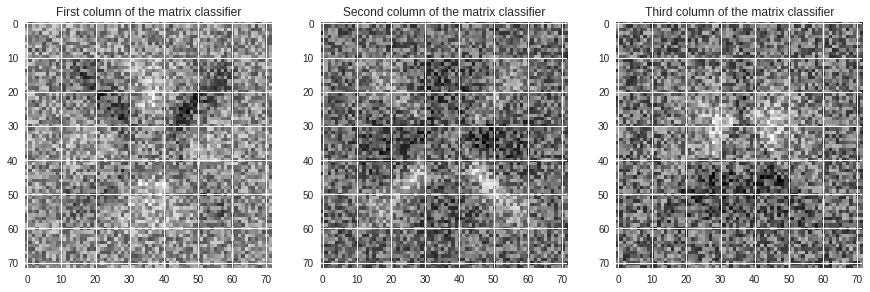

In [11]:
weights = linear_classifier.get_weights()
classifier_matrix = weights[0]
l, n_class = classifier_matrix.shape

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(classifier_matrix[:,0].reshape(int(np.sqrt(l)),int(np.sqrt(l))), cmap='gray'); 
plt.title("First column of the matrix classifier")

plt.subplot(132)
plt.imshow(classifier_matrix[:,1].reshape(int(np.sqrt(l)),int(np.sqrt(l))), cmap='gray'); 
plt.title("Second column of the matrix classifier")

plt.subplot(133)
plt.imshow(classifier_matrix[:,2].reshape(int(np.sqrt(l)),int(np.sqrt(l))), cmap='gray'); 
plt.title("Third column of the matrix classifier")
plt.show()

### b. Weigths of the classifier trained with Adam

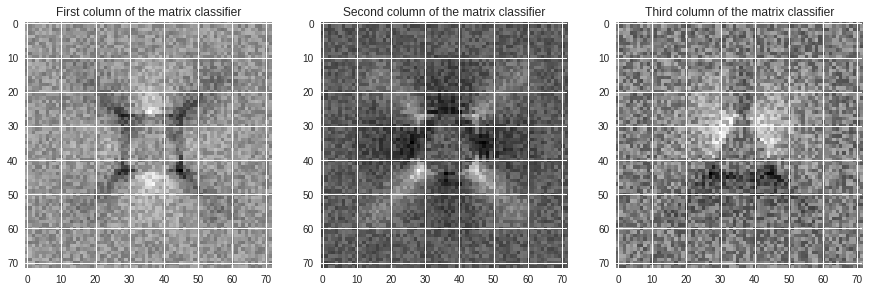

In [13]:
weights_adam = linear_adam.get_weights()
classifier_matrix_adam = weights_adam[0]
l, n_class = classifier_matrix_adam.shape

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(classifier_matrix_adam[:,0].reshape(int(np.sqrt(l)),int(np.sqrt(l))), cmap='gray'); 
plt.title("First column of the matrix classifier")

plt.subplot(132)
plt.imshow(classifier_matrix_adam[:,1].reshape(int(np.sqrt(l)),int(np.sqrt(l))), cmap='gray'); 
plt.title("Second column of the matrix classifier")

plt.subplot(133)
plt.imshow(classifier_matrix_adam[:,2].reshape(int(np.sqrt(l)),int(np.sqrt(l))), cmap='gray'); 
plt.title("Third column of the matrix classifier")
plt.show()

# 3. More difficult classification problem

### a. With a linear classifier

In [14]:
# Loading training dataset
n_train = 500
n_val = 50
n_test = 50
noise = 20

# Generate training, validation and testing sets
[X_train, Y_train] = generate_dataset_classification(n_train, noise, True)
[X_val, Y_val] = generate_test_set_classification(n_val, noise, True)
[X_test, Y_test] = generate_test_set_classification(n_test, noise, True)

print('Converting labels to one-hot labels')
Y_train = keras.utils.to_categorical(Y_train)
Y_val = keras.utils.to_categorical(Y_val)
Y_test = keras.utils.to_categorical(Y_test)

Creating data:.....FinishedCreating data:.FinishedCreating data:.FinishedConverting labels to one-hot labels


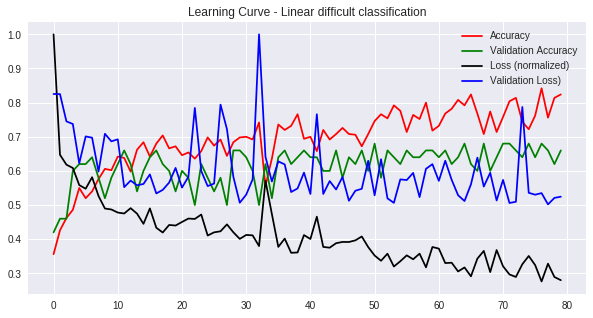

Accuracy over test set :  0.6600000071525574


In [15]:
linear_clf2 = my_linear_classifier(X_train, lr=0.001, optimizer='Adam')

n_epochs = 80
history_clf2 = linear_clf2.fit(X_train, Y_train, 
                               epochs=n_epochs, 
                               batch_size=32, 
                               validation_data = [X_val, Y_val],
                               verbose=0)

# Learning curves : Losses and Accuracies over time
plt.figure(figsize=(10,5))
plt.plot(history_clf2.history['acc'], 'r', label='Accuracy')
plt.plot(history_clf2.history['val_acc'], 'g', label='Validation Accuracy')
plt.plot(history_clf2.history['loss']/np.max(history_clf2.history['loss']), 'k', label='Loss (normalized)')
plt.plot(history_clf2.history['val_loss']/np.max(history_clf2.history['val_loss']), 'b', label='Validation Loss)')
plt.legend()
plt.title('Learning Curve - Linear difficult classification')
plt.show()

# Model Evaluation
print('Accuracy over test set : ', linear_clf2.evaluate(X_test, Y_test, verbose=0)[1])

### b. With a deep CNN

In [0]:
# Give the right format to the input data

n_samples, l = X_train.shape
_, n_class = Y_train.shape
rows = int(np.sqrt(l))
cols = int(np.sqrt(l))
channels=1

X_train_cnn = np.reshape(X_train, (n_samples, rows, cols,  channels))
Y_train_cnn = np.reshape(Y_train, (n_samples, n_class))

X_val_cnn = np.reshape(X_val, (n_val, rows, cols,  channels))
Y_val_cnn = np.reshape(Y_val, (n_val, n_class))

X_test_cnn = np.reshape(X_test, (n_test, rows, cols,  channels))
Y_test_cnn = np.reshape(Y_test, (n_test, n_class))

In [0]:
# Creating the model
# Using 3x3 filters is way more computationally efficient than bigger filters ... cf. effective receptive fields 

def my_deep_cnn(X_train, lr=0.001, n_classes=3, loss='categorical_crossentropy', metric='accuracy'):
    n_samples, l = X_train.shape
    rows = int(np.sqrt(l))
    cols = int(np.sqrt(l))
    channels=1
    
    cnn = Sequential()
    cnn.add(Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=(rows, cols, channels)))
    cnn.add(MaxPool2D(pool_size=2))
    cnn.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
    cnn.add(Flatten())
    cnn.add(Dense(n_classes, activation='softmax'))

    cnn.compile(optimizer=Adam(lr=lr), loss=loss, metrics=[metric])
    return cnn

In [20]:
# Training the model
cnn = my_deep_cnn(X_train, lr=0.001)

n_epochs = 80
history_cnn = cnn.fit(X_train_cnn, Y_train_cnn, epochs=n_epochs, 
                      batch_size=32,
                      validation_data = [X_val_cnn, Y_val_cnn], 
                      verbose=1)

Train on 500 samples, validate on 50 samples
Epoch 1/80
500/500 [==============================] - 1s 1ms/step - loss: 1.1434 - acc: 0.3620 - val_loss: 1.0217 - val_acc: 0.5200
Epoch 2/80
500/500 [==============================] - 0s 301us/step - loss: 0.9924 - acc: 0.5720 - val_loss: 0.9060 - val_acc: 0.6800
Epoch 3/80
500/500 [==============================] - 0s 305us/step - loss: 0.8551 - acc: 0.6780 - val_loss: 0.7533 - val_acc: 0.6600
Epoch 4/80
500/500 [==============================] - 0s 311us/step - loss: 0.7411 - acc: 0.6860 - val_loss: 0.6896 - val_acc: 0.7000
Epoch 5/80
500/500 [==============================] - 0s 322us/step - loss: 0.6833 - acc: 0.7240 - val_loss: 0.6677 - val_acc: 0.7200
Epoch 6/80
500/500 [==============================] - 0s 305us/step - loss: 0.6041 - acc: 0.7700 - val_loss: 0.6226 - val_acc: 0.7400
Epoch 7/80
500/500 [==============================] - 0s 311us/step - loss: 0.5333 - acc: 0.8080 - val_loss: 0.5695 - val_acc: 0.7400
Epoch 8/80
500/500 

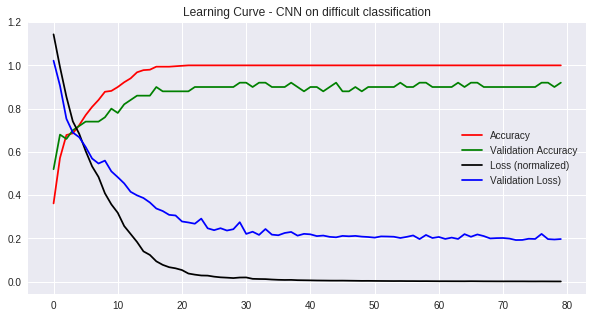

Accuracy over test set :  0.9200000023841858


In [22]:

# Learning curves : Losses and Accuracies over time
plt.figure(figsize=(10,5))
plt.plot(history_cnn.history['acc'], 'r', label='Accuracy')
plt.plot(history_cnn.history['val_acc'], 'g', label='Validation Accuracy')
plt.plot(history_cnn.history['loss'], 'k', label='Loss (normalized)')
plt.plot(history_cnn.history['val_loss'], 'b', label='Validation Loss)')
plt.legend()
plt.title('Learning Curve - CNN on difficult classification')
plt.show()

# Model Evaluation
print('Accuracy over test set : ', cnn.evaluate(X_test_cnn, Y_test_cnn, verbose=0)[1])

# 5. Image denoising with an Hourglass Network


**Results**


In the results, when I compare training sample - prediction - groundtruth, you can see, eventhough denoising is not perfect, the hourglass smoothes the noise over the image.

In [0]:
def generate_dataset_denoising(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    
    sys.stdout.write('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            sys.stdout.write('.')
        category = np.random.randint(3)
        if category == 0:
            Y[i] = generate_a_rectangle(0, free_location) 
        elif category == 1: 
            Y[i] = generate_a_disk(0, free_location)
        else:
            Y[i], _ = generate_a_triangle(0, free_location)
            
        X[i] = (Y[i] + noise * np.random.random(Y[i].size)) / (255 + 2*noise)
    sys.stdout.write(' Finished | ')
    return [X, Y]

def generate_test_set_denoising(n_samples, noise, free_location=False):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(n_samples, noise, free_location)
    return [X_test, Y_test]

Creating data:.................................................................................................... Finished | Creating data:..... Finished | Creating data:..... Finished | 

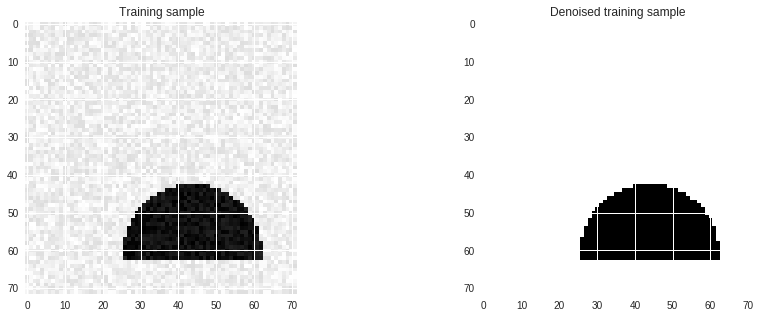

In [125]:
n_train = 1000
n_val = 50
n_test =50
noise = 40

X_train, Y_train = generate_dataset_denoising(n_train, noise, True)
X_val, Y_val = generate_dataset_denoising(n_val, noise, True)
X_test, Y_test = generate_dataset_denoising(n_test, noise, True)

_, l = X_train.shape
_, n_classes = Y_train.shape
rows = int(np.sqrt(l))
cols = int(np.sqrt(l))
channels = 1

# Vizualising the training data
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(X_train[1,:].reshape((rows,cols)), cmap='gray'); plt.title('Training sample')
plt.subplot(122)
plt.imshow(Y_train[1,:].reshape((rows,cols)), cmap='gray'); plt.title('Denoised training sample')
plt.show()

In [0]:
X_train_hg = np.reshape(X_train, (n_train, rows, cols,  channels))
Y_train_hg = np.reshape(Y_train, (n_train, rows, cols,  channels))

X_val_hg = np.reshape(X_val, (n_val, rows, cols,  channels))
Y_val_hg = np.reshape(Y_val, (n_val, rows, cols,  channels))

X_test_hg = np.reshape(X_test, (n_test, rows, cols,  channels))
Y_test_hg = np.reshape(Y_test, (n_test, rows, cols,  channels))

In [0]:
from tensorflow.keras.layers import UpSampling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras import Model


def my_hourglass(lr=0.02, decay=0, loss='mse'):

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(rows,cols,channels) , padding='same', kernel_initializer='glorot_normal'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal'))
    
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(1, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal'))
    model.summary()
    
    model.compile(loss=loss,optimizer=Adam(lr=lr))
    return model

In [136]:
hourglass = my_hourglass(lr=0.005, loss='mse')
n_epochs = 100

his_hourglass = hourglass.fit(X_train_hg, Y_train_hg, 
                              epochs=n_epochs, 
                              batch_size=32,
                              verbose=1, 
                              validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_178 (Conv2D)          (None, 72, 72, 32)        320       
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 18, 18, 32)        9248      
_________________________________________________________________
up_sampling2d_80 (UpSampling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 36, 36, 32)        9248      
__________

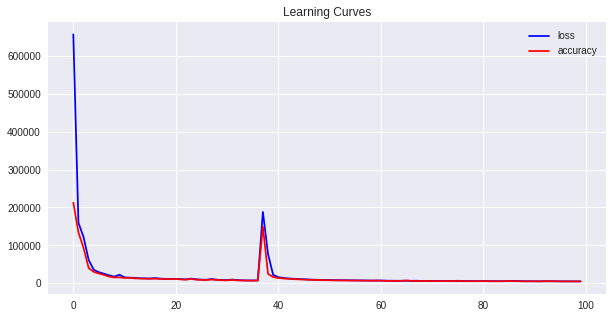

In [137]:
# Plotting the learning curve
hg_loss = his_hourglass.history['loss']
hg_val_loss = his_hourglass.history['val_loss']

plt.figure(figsize=(10,5))
plt.plot(hg_loss, 'b', label='loss')
plt.plot(hg_val_loss, 'r', label='accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()

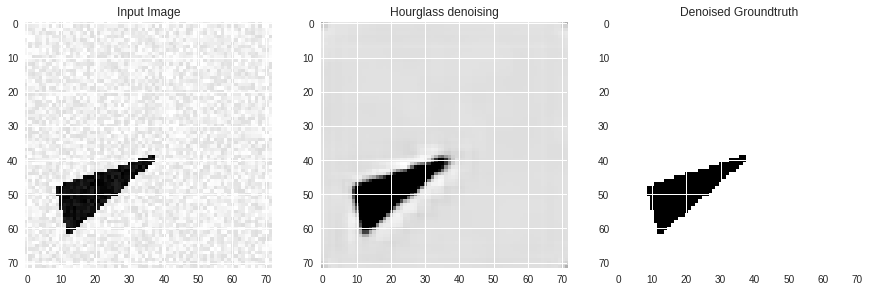

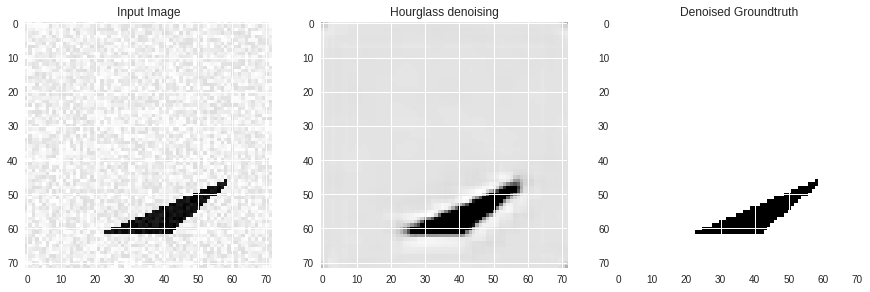

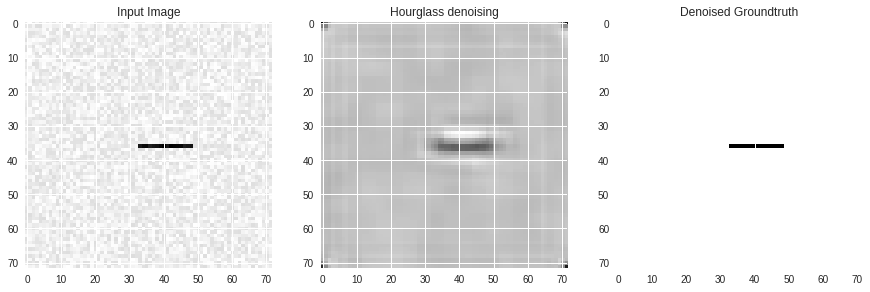

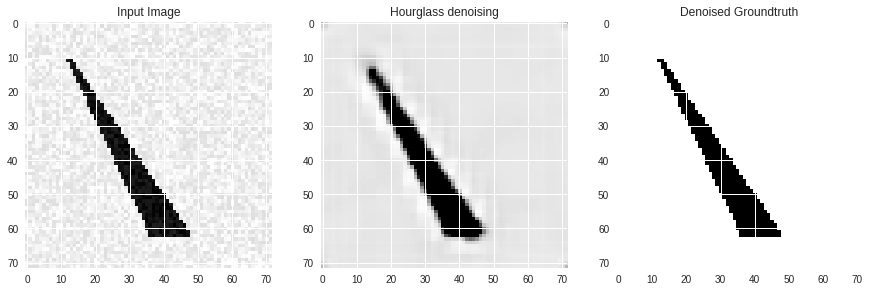

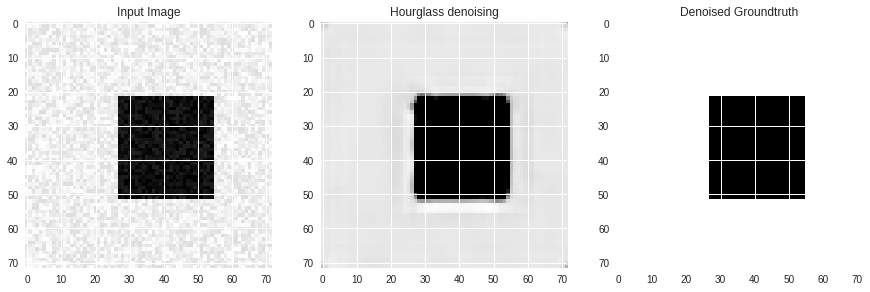

In [138]:
Y_pred = hourglass.predict(X_val_hg, steps=1)

l,a,_,_ = Y_pred.shape
for i in range(5):
    plt.figure(figsize=(15,10))
    plt.subplot(131)
    plt.imshow(X_val[i,:].reshape((a,a)), cmap='gray')
    plt.title('Input Image')
    plt.subplot(133)
    plt.imshow(Y_val[i,:].reshape((a, a)), cmap='gray')
    plt.title('Denoised Groundtruth')
    plt.subplot(132)
    plt.imshow(Y_pred[i,:,:,0], cmap='gray')
    plt.title('Hourglass denoising')
    plt.show()
    